In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, convert_weekly_panel_to_biweekly_panel, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_0_crimes_50m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_weekly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [2]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_week'
df = df.dropna(subset=treatment_date_variable)
df = convert_weekly_panel_to_biweekly_panel(df, treatment_date_variable, analysis)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [3]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                                                 
                                                 \emph{Independent Variable}                                     
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_50m       5.648070e-195   
                                                 pre_treatment_change_in_group_0_crimes_50m       6.862011e-02   
Panel B: Census Tract Characteristics            frac_coll_plus2010                               5.193974e-04   
                                                 job_density_2013                                 3.046387e-30   
                                                 med_hhinc2016                                    7.337340e-01   
                                                 poor_share2010                                   1.433225e-04   
                                                 popdensity2010                                   7.893866e-05   
Panel C: Case Initiation                         for_cause                                        3.010275e-01   
                                                 no_cause                                         4.059382e-01   
                                                 non_payment                                      1.357431e-01   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                         2.226504e-01   
                                                 hasAttyP                                         2.741967e-02   
                                                 isEntityD                                        5.584324e-06   
                                                 isEntityP                                        5.570233e-04   

                                                                                                           
                                                                                                           
                                                 \emph{Independent Variable}                               
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_50m   9.116859e-02  
                                                 pre_treatment_change_in_group_0_crimes_50m  4.407802e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010                          2.196947e-01  
                                                 job_density_2013                            1.019090e-01  
                                                 med_hhinc2016                               4.881476e-02  
                                                 poor_share2010                              9.587528e-01  
                                                 popdensity2010                              2.446323e-03  
Panel C: Case Initiation                         for_cause                                   1.210370e-09  
                                                 no_cause                                    9.538294e-01  
                                                 non_payment                                 3.799494e-08  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                    1.768454e-03  
                                                 hasAttyP                                    3.747346e-04  
                                                 isEntityD                                   6.440755e-02  
                                                 isEntityP                                   4.931512e-07

In [4]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                                  Cases Won by Plaintiff   
Panel A total_twenty_seventeen_group_0_crimes_50m              19.295311   
Panel B frac_coll_plus2010                                      0.330934   
        job_density_2013                                    17324.753036   
        poor_share2010                                          0.275051   
        popdensity2010                                      23285.588974   
Panel D hasAttyP                                                0.875158   
        isEntityD                                               0.017110   
        isEntityP                                               0.805450   

                                                  Difference in Cases Won by Defendant  \
                                                                            Unweighted   
Panel A total_twenty_seventeen_group_0_crimes_50m                             1.580929   
Panel B frac_coll_plus2010                                                    0.009828   
        job_density_2013                                                   2509.701466   
        poor_share2010                                                       -0.000268   
        popdensity2010                                                     1452.046732   
Panel D hasAttyP                                                             -0.039492   
        isEntityD                                                            -0.009771   
        isEntityP                                                            -0.066862   

                                                                             \
                                                       \emph{p}    Weighted   
Panel A total_twenty_seventeen_group_0_crimes_50m  9.116859e-02   -0.251017   
Panel B frac_coll_plus2010                         2.196947e-01   -0.004616   
        job_density_2013                           1.019090e-01 -205.756345   
        poor_share2010                             9.587528e-01   -0.003989   
        popdensity2010                             2.446323e-03 -311.132382   
Panel D hasAttyP                                   3.747346e-04   -0.013387   
        isEntityD                                  6.440755e-02   -0.000424   
        isEntityP                                  4.931512e-07   -0.012870   

                                                             
                                                   \emph{p}  
Panel A total_twenty_seventeen_group_0_crimes_50m  0.780940  
Panel B frac_coll_plus2010                         0.552805  
        job_density_2013                           0.890324  
        poor_share2010                             0.442593  
        popdensity2010                             0.442579  
Panel D hasAttyP                                   0.201531  
        isEntityD                                  0.934276  
        isEntityP                                  0.228821

In [5]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [6]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=34]  100%|████████████████████| 17776/17776 [01:47<00:00, 164.99it/s]


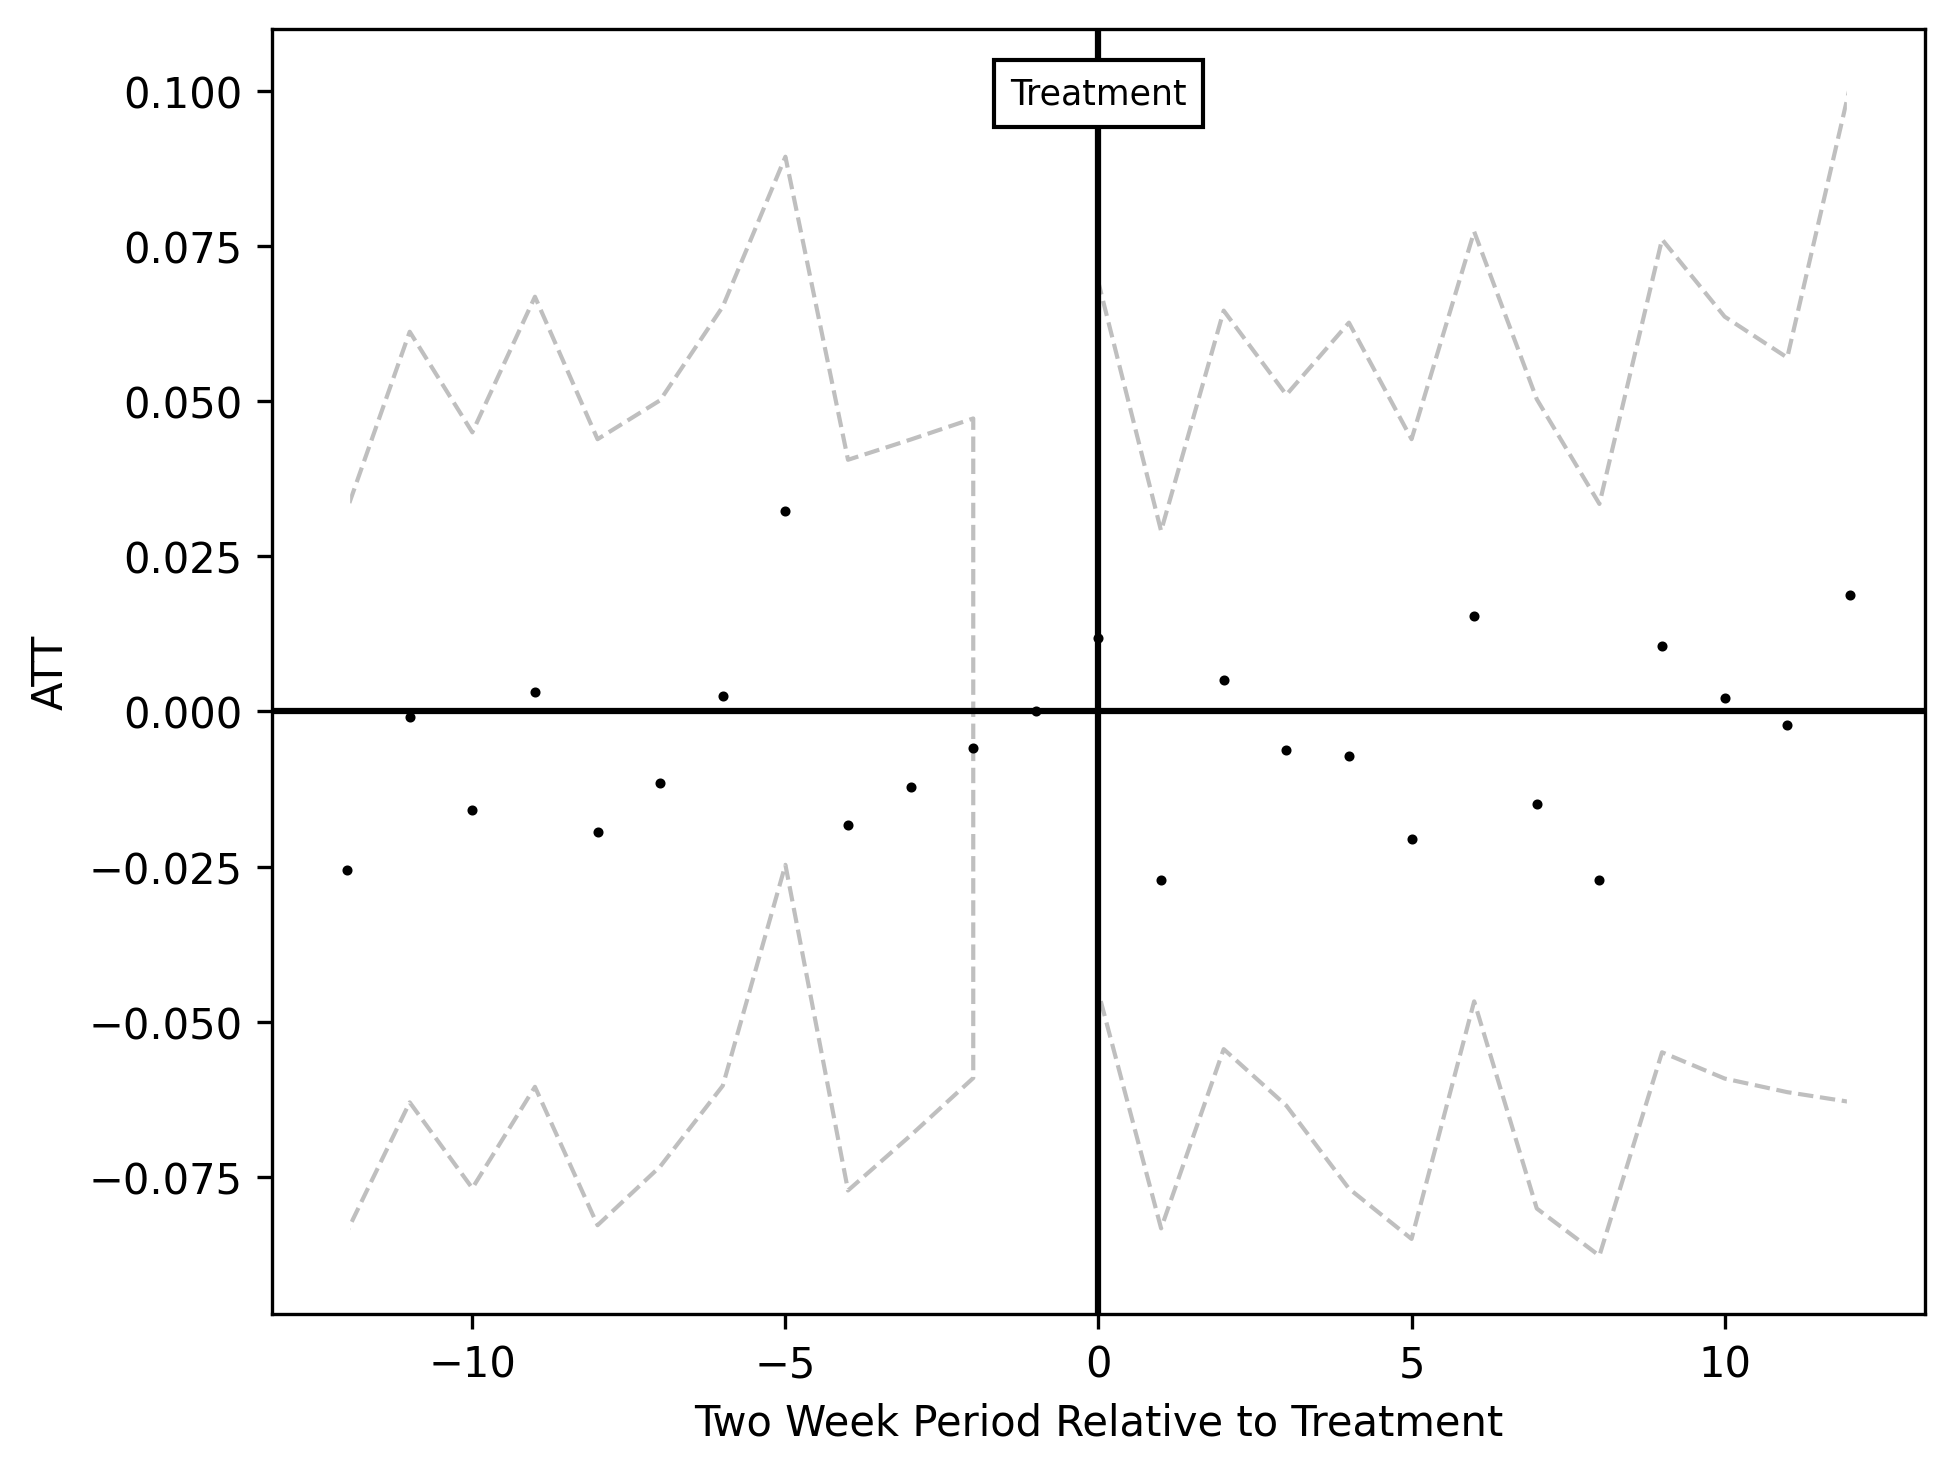

In [7]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-12, end_period=12,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

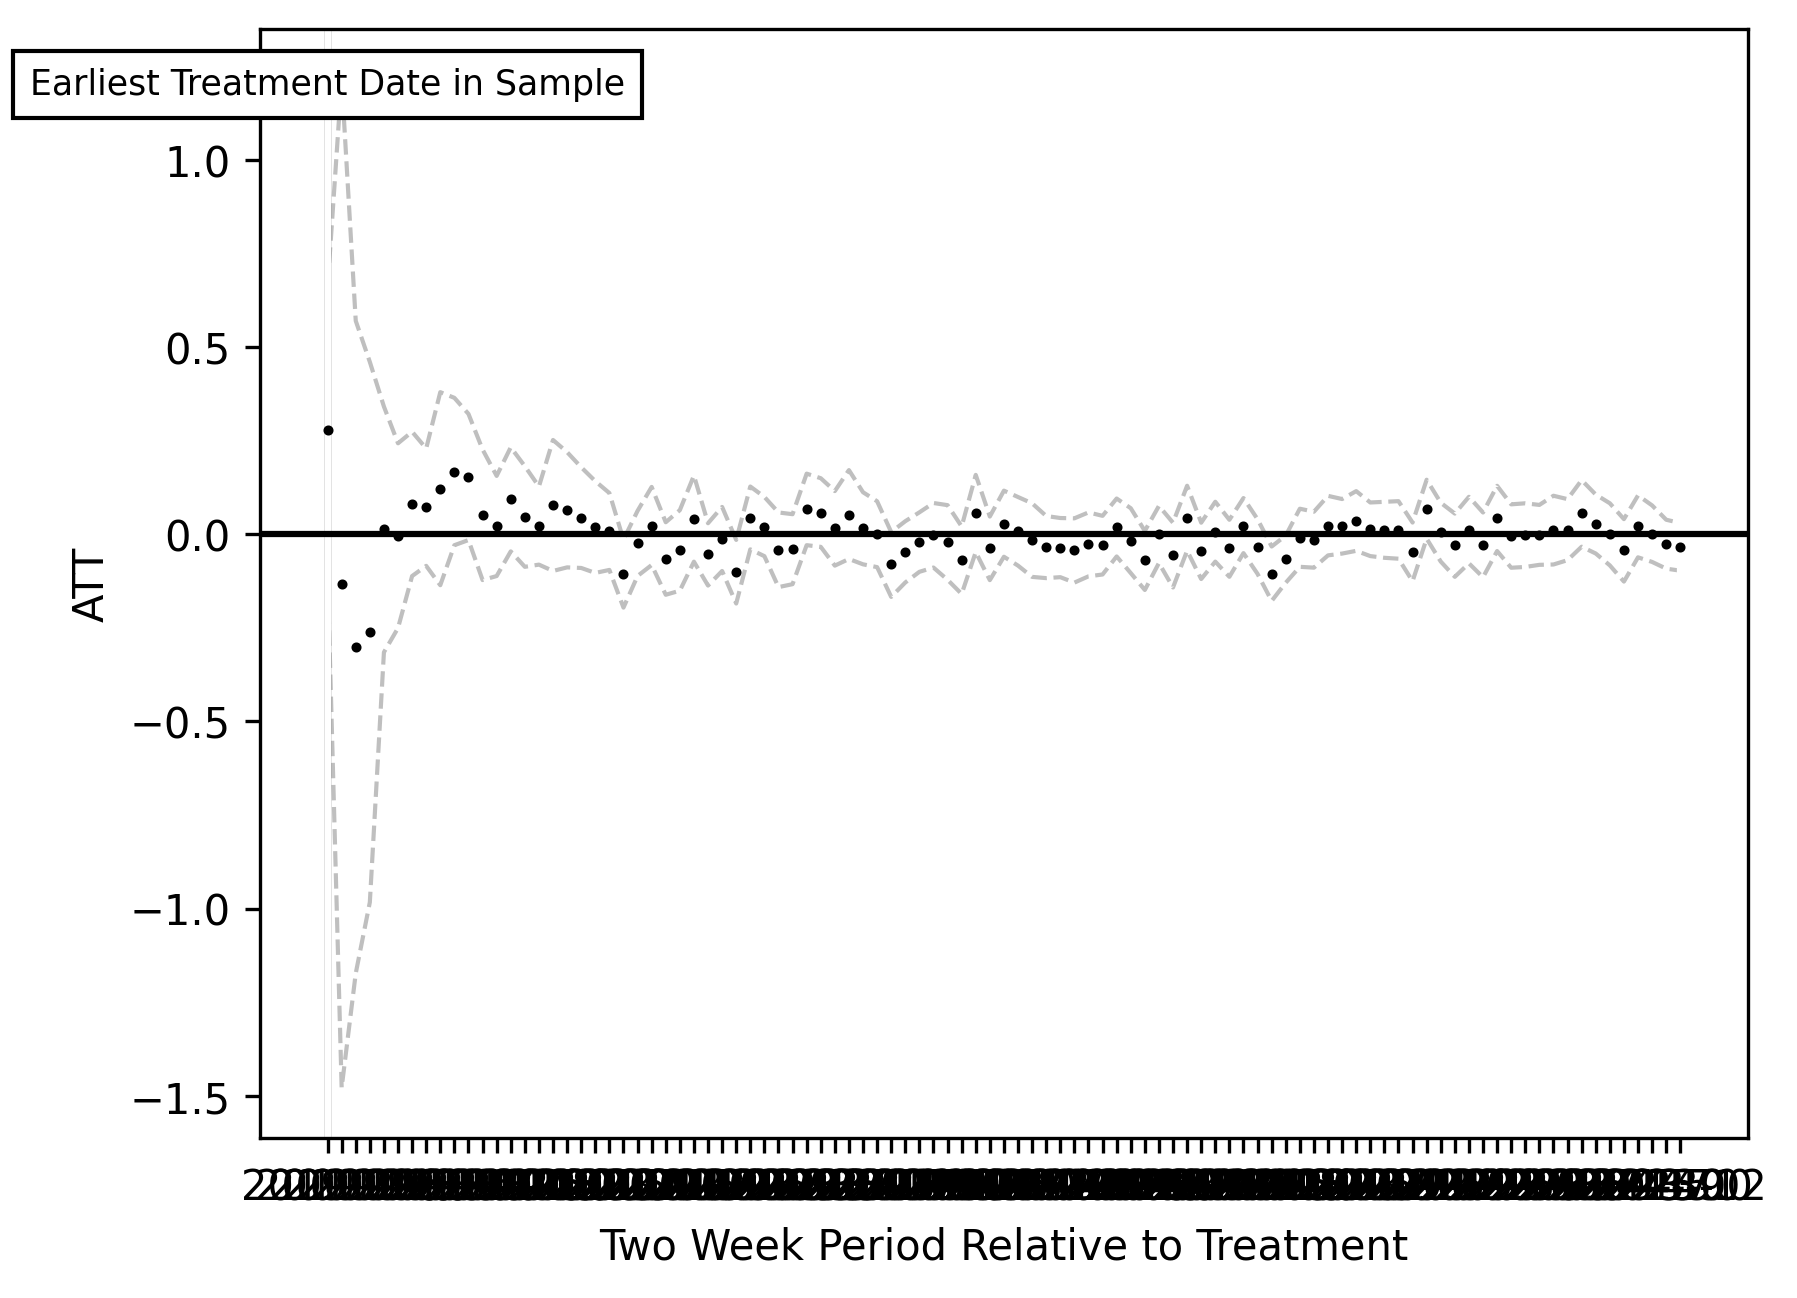

In [8]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="")

In [9]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=34]   36%|███████▎            | 6454/17776 [01:36<02:07, 88.50it/s] /gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
Computing ATTgt [workers=34]   36%|███████▎            | 6463/17776 [01:36<02:22, 79.26it/s]/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow e

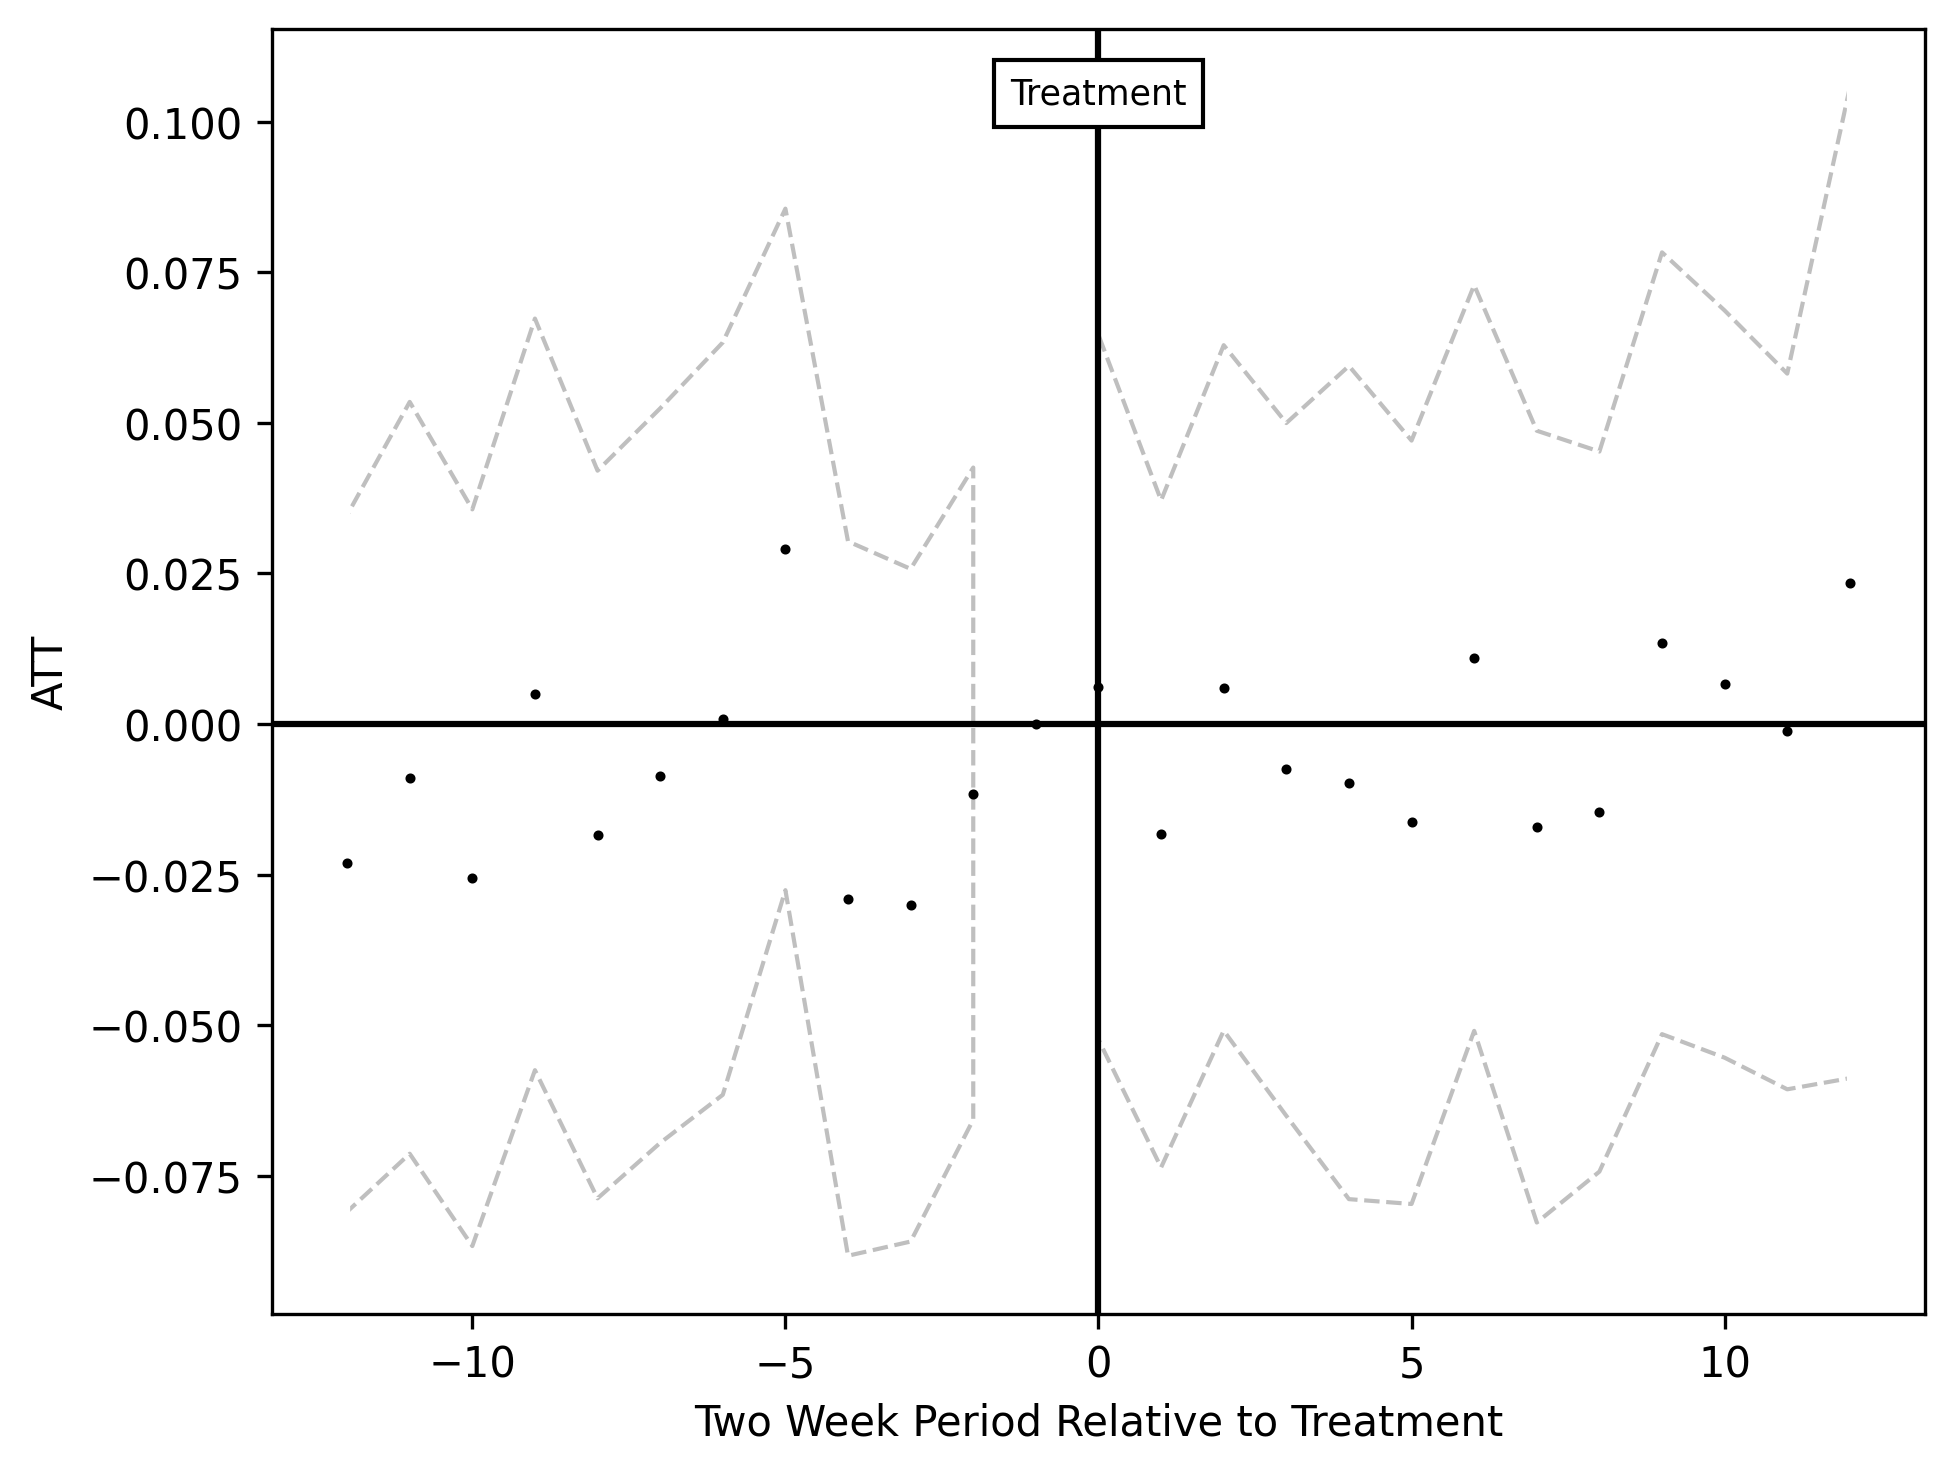

In [10]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-12,
                                 end_period=12,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

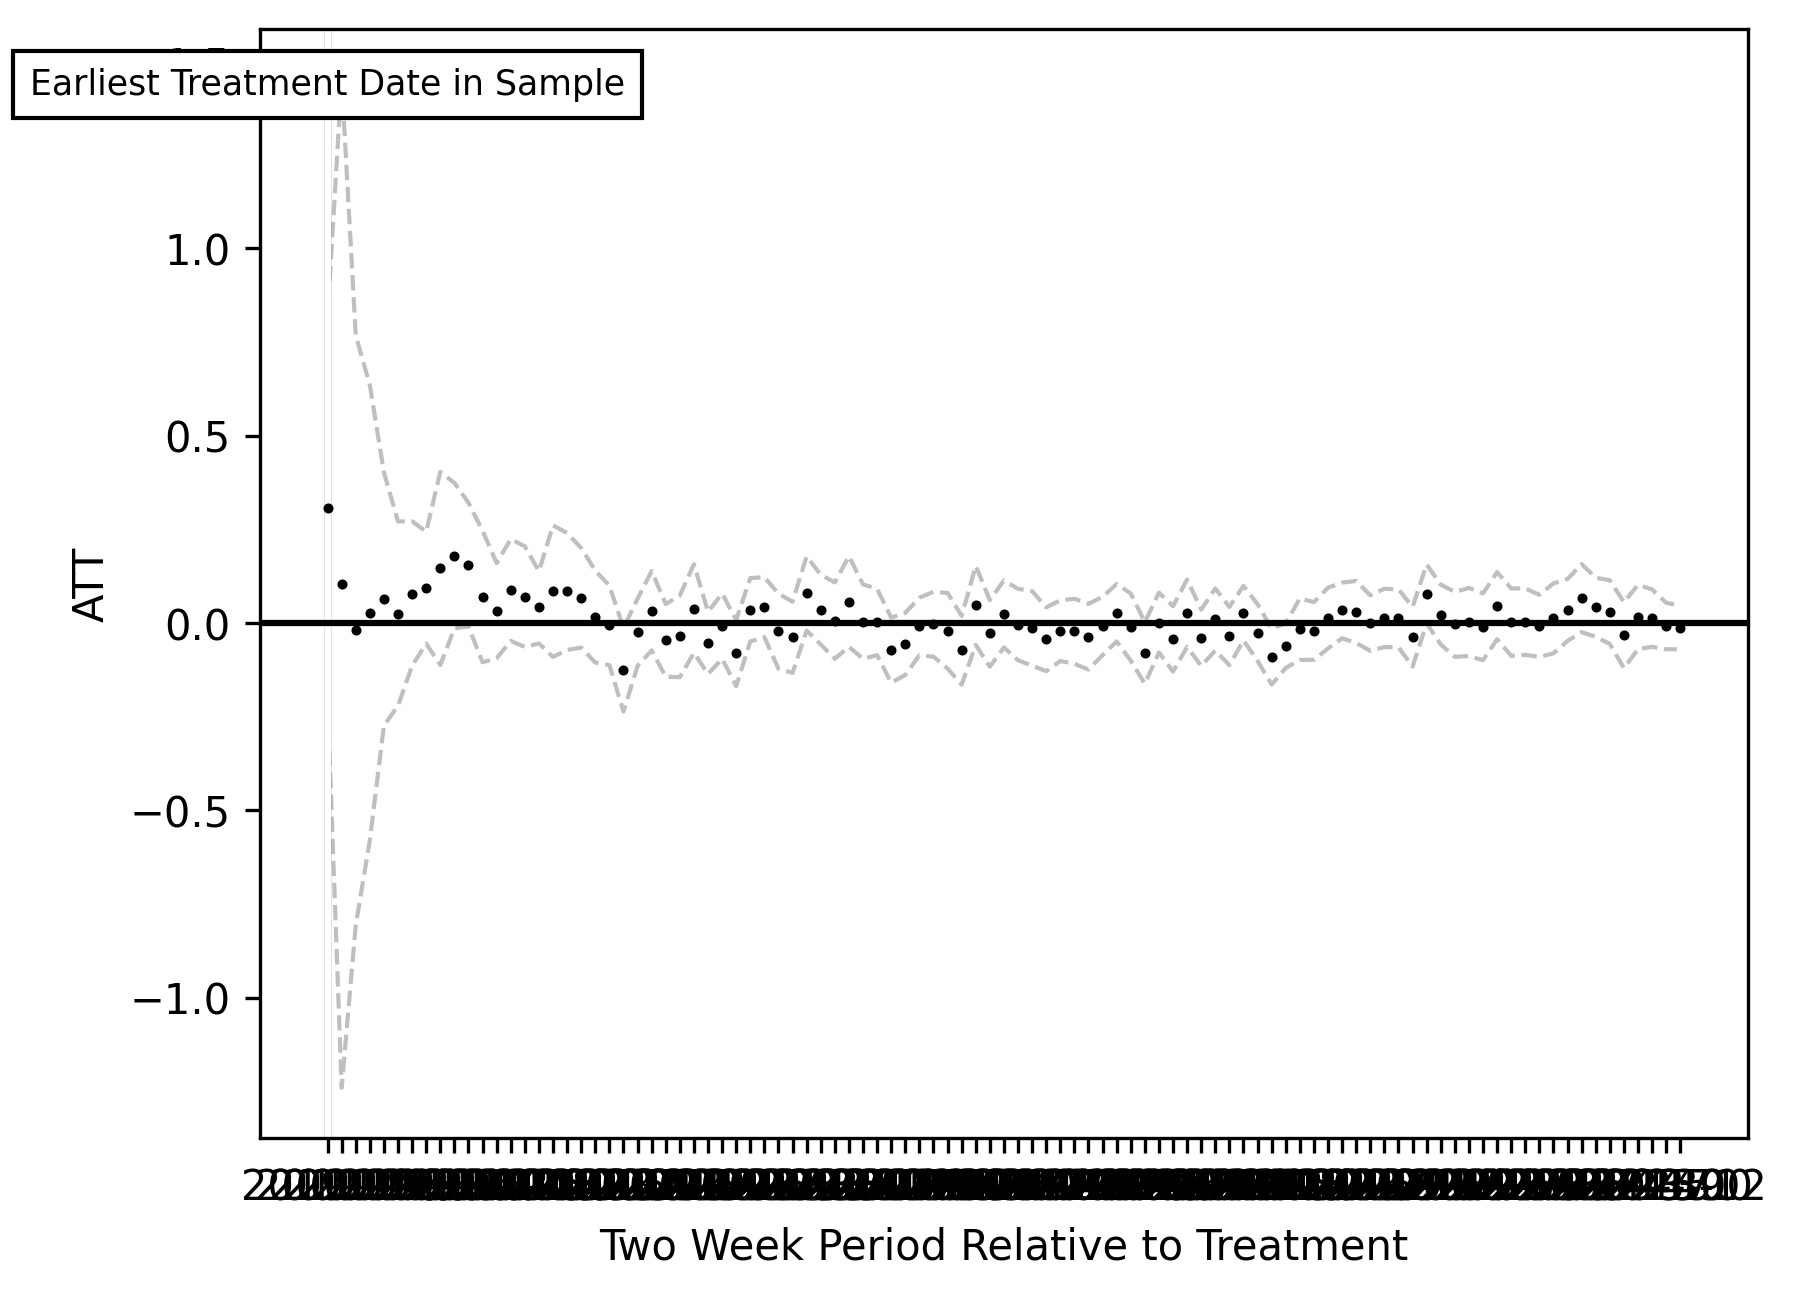

In [11]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="")